In [1]:
# Libraries

import json
import numpy
import os
import platform
import shutil
import sys

In [2]:
# Root directory

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux' :
			ROOT = '/d/hpc/home/up4472/workspace/upolanc-thesis'
		elif platform.system() == 'Windows' :
			ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else :
			raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Code

from source.python.cnn.models import Zrimec2020c

from source.python.cnn import core     as cnn_core
from source.python.cnn import dataset  as cnn_dataset
from source.python.cnn import model    as cnn_model
from source.python.cnn import mutation as cnn_mutation
from source.python.cnn import plot     as cnn_plot
from source.python.cnn import util     as cnn_util
from source.python.io  import loader   as data_loader

# 1. Setup

In [4]:
# Setup some directory paths.

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA  = os.path.join(OUT,      'nbp07-zrimec2020', 'classification')
OUT_MODEL = os.path.join(OUT_DATA, 'model')
OUT_PLOT  = os.path.join(OUT_DATA, 'plot')
RES_NBP04 = os.path.join(OUT,      'nbp04-feature')
RES_NBP05 = os.path.join(OUT,      'nbp05-target')

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA,  exist_ok = True)
os.makedirs(OUT_MODEL, exist_ok = True)
os.makedirs(OUT_PLOT,  exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f'   Output Directory : {OUT_MODEL}')
print(f'   Output Directory : {OUT_PLOT}')
print(f' Resource Directory : {RES_NBP04}')
print(f' Resource Directory : {RES_NBP05}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp07-zrimec2020\classification
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp07-zrimec2020\classification\model
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp07-zrimec2020\classification\plot
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp04-feature
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp05-target


In [5]:
# System and device

DEVICE = cnn_core.get_device(only_cpu = False)
SYSTEM = cnn_core.get_system_info()

for key, value in SYSTEM.items() :
	print('{:25s} : {}'.format(key, value))

platform/python           : 3.10.7
platform/system           : Windows
platform/release          : 10
platform/version          : 10.0.19044
platform/cpu/name         : N/A
platform/cpu/count        : 12
platform/gpu/name         : NVIDIA GeForce RTX 3060 Ti
platform/gpu/available    : True
platform/gpu/count        : 1
platform/memory/total     : 31.924 GB
platform/memory/available : 4.189 GB


In [6]:
# Load the input transcript features

mutation_feature_sequence = data_loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'mutation-features-bp2150.fasta'),
	to_string = True
)

mutation_feature_frequency = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'mutation-features-frequency.npz')
)

mutation_feature_stability = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'mutation-features-stability.npz')
)

mutation_feature_base = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'mutation-features-base.npz')
)

feature_sequence = data_loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'features-bp2150.fasta'),
	to_string = True
)

feature_frequency = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-frequency.npz')
)

feature_stability = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-stability.npz')
)

feature_base = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-base.npz')
)

target_label = data_loader.load_labels(
	filename = os.path.join(RES_NBP05, 'target-labels.json'),
	to_numpy = True
)

target_order = data_loader.load_labels(
	filename = os.path.join(RES_NBP05, 'target-order.json')
)

# 2. Config

In [7]:
# Select target

TARGET_GROUP  = 'tissue'
TARGET_TYPE   = 'mean'
TARGET_FILTER = None
TARGET_SIZE   = -1
TARGET_HEADS  = -1

target_order = target_order[TARGET_GROUP]
target_label = {
	key : value[TARGET_GROUP + '-' + TARGET_TYPE]
	for key, value in target_label.items()
}

if TARGET_FILTER is not None :
	index = target_order[TARGET_GROUP].index(TARGET_FILTER)

	target_order = [target_order[index]]
	target_label = {
		key : value[index:index + 1]
		for key, value in target_label.items()
	}

TARGET_HEADS = len(target_order)
TARGET_SIZE  = len(numpy.unique([value for value in target_label.values()]))

In [8]:
# Ensure long dtype

target_label = {
	key : value.astype(numpy.int64)
	for key, value in target_label.items()
}

In [9]:
# Single config

CONFIG = {
	'core/random'  : None,
	'core/verbose' : True,
	'core/device'  : DEVICE,
	'core/rootdir' : ROOT,

	'dataset/expanddim'   : None,
	'dataset/batch/train' : 32,
	'dataset/batch/valid' : 32,
	'dataset/batch/test'  : 32,
	'dataset/split/valid' : 0.2,
	'dataset/split/test'  : 0.2,

	'criterion/name'      : 'entropy',
	'criterion/reduction' : 'mean',

	'optimizer/name'     : 'adam',
	'optimizer/lr'       : 0.001,
	'optimizer/decay'    : 0.01,
	'optimizer/momentum' : 0.97,

	'scheduler/name'               : 'plateau',
	'scheduler/plateau/factor'     : 0.5,
	'scheduler/plateau/patience'   : 5,
	'scheduler/linear/factor'      : 1e-5,
	'scheduler/step/factor'        : 0.5,
	'scheduler/step/patience'      : 5,
	'scheduler/exponential/factor' : 0.98,

	'model/input/channels' : 1,
	'model/input/height'   : 4,
	'model/input/width'    : 2150,
	'model/input/features' : 64,

	'model/epochs'    : 5,
	'model/dropout'   : 0.1,
	'model/leakyrelu' : 0.0,

	'model/conv1/filters'  : 64,
	'model/conv1/kernel'   : 21,
	'model/conv1/padding'  : 'none',
	'model/conv1/dilation' : 1,
	'model/conv2/filters'  : 64,
	'model/conv2/kernel'   : 31,
	'model/conv2/padding'  : 'none',
	'model/conv2/dilation' : 1,
	'model/conv3/filters'  : 128,
	'model/conv3/kernel'   : 5,
	'model/conv3/padding'  : 'same',
	'model/conv3/dilation' : 1,

	'model/maxpool1/kernel'  : 5,
	'model/maxpool1/stride'  : 5,
	'model/maxpool1/padding' : 'same',
	'model/maxpool2/kernel'  : 3,
	'model/maxpool2/stride'  : 3,
	'model/maxpool2/padding' : 'same',
	'model/maxpool3/kernel'  : 3,
	'model/maxpool3/stride'  : 3,
	'model/maxpool3/padding' : 'same',

	'model/fc1/features' : 128,
	'model/fc2/features' : 256,
	'model/fc3/features' : TARGET_SIZE,
	'model/fc3/heads'    : TARGET_HEADS,

	'model/output/target' : TARGET_GROUP,
	'model/output/type'   : TARGET_TYPE,
	'model/output/filter' : TARGET_FILTER,
	'model/output/size'   : TARGET_SIZE,
	'model/output/heads'  : TARGET_HEADS
}

CONFIG['core/random'] = cnn_core.lock_random(
	seed     = CONFIG['core/random'],
	generate = True
)

print('Random Seed : {}'.format(CONFIG['core/random']))

Random Seed : 542805262


# 3. Dataloaders

## 3.1 Normal

In [10]:
# Create dataloader

dataset = cnn_dataset.to_dataset(
	sequences   = feature_sequence,
	features    = feature_frequency,
	targets     = target_label,
	expand_dims = CONFIG['dataset/expanddim']
)

dataloaders = cnn_dataset.to_dataloaders(
	dataset     = dataset,
	random_seed = CONFIG['core/random'],
	split_size  = {
		'valid' : CONFIG['dataset/split/valid'],
		'test'  : CONFIG['dataset/split/test']
	},
	batch_size  = {
		'train' : CONFIG['dataset/batch/train'],
		'valid' : CONFIG['dataset/batch/valid'],
		'test'  : CONFIG['dataset/batch/test']
	}
)

train_dataloader = dataloaders[0]
valid_dataloader = dataloaders[1]
test_dataloader  = dataloaders[2]

In [11]:
# Display train dataloader

cnn_dataset.show_dataloader(
	dataloader = train_dataloader,
	verbose    = CONFIG['core/verbose']
)

     Key Shape : (32,)
Sequence Shape : torch.Size([32, 4, 2150])
 Feature Shape : torch.Size([32, 64])
  Target Shape : torch.Size([32, 5])

 Batch Size  :     32
 Batch Count :    608
Sample Count : 19,456


In [12]:
# Display valid dataloader

cnn_dataset.show_dataloader(
	dataloader = valid_dataloader,
	verbose    = CONFIG['core/verbose']
)

     Key Shape : (32,)
Sequence Shape : torch.Size([32, 4, 2150])
 Feature Shape : torch.Size([32, 64])
  Target Shape : torch.Size([32, 5])

 Batch Size  :     32
 Batch Count :    152
Sample Count :  4,864


In [13]:
# Display test dataloader

cnn_dataset.show_dataloader(
	dataloader = test_dataloader,
	verbose    = CONFIG['core/verbose']
)

     Key Shape : (32,)
Sequence Shape : torch.Size([32, 4, 2150])
 Feature Shape : torch.Size([32, 64])
  Target Shape : torch.Size([32, 5])

 Batch Size  :     32
 Batch Count :    190
Sample Count :  6,080


## 3.2 Mutation

In [14]:
# Create mutation dataloader

mutation_dataloader = cnn_mutation.create_dataloader(
	sequences   = mutation_feature_sequence,
	features    = mutation_feature_frequency,
	targets     = target_label,
	expand_dims = CONFIG['dataset/expanddim'],
	random_seed = CONFIG['core/random']
)

In [15]:
# Display mutation dataloader

cnn_dataset.show_dataloader(
	dataloader = mutation_dataloader,
	verbose    = CONFIG['core/verbose']
)

     Key Shape : (1,)
Sequence Shape : torch.Size([1, 4, 2150])
 Feature Shape : torch.Size([1, 64])
  Target Shape : torch.Size([1, 5])

 Batch Size  :      1
 Batch Count :  2,525
Sample Count :  2,525


# 4. Model

## 4.1 Structure

In [16]:
# Create and display the model structure

model = Zrimec2020c(params = CONFIG)

model.summary(
	batch_size  = CONFIG['dataset/batch/train'],
	in_height   = CONFIG['model/input/height'],
	in_width    = CONFIG['model/input/width'],
	in_features = CONFIG['model/input/features']
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Zrimec2020c                              [32, 4, 2150]             [32, 5, 5]                --
├─Zrimec2020: 1-1                        [32, 4, 2150]             [32, 256]                 --
│    └─Conv1d: 2-1                       [32, 4, 2150]             [32, 64, 2130]            5,440
│    └─LeakyReLU: 2-2                    [32, 64, 2130]            [32, 64, 2130]            --
│    └─BatchNorm1d: 2-3                  [32, 64, 2130]            [32, 64, 2130]            128
│    └─Dropout: 2-4                      [32, 64, 2130]            [32, 64, 2130]            --
│    └─MaxPool1d: 2-5                    [32, 64, 2130]            [32, 64, 426]             --
│    └─Conv1d: 2-6                       [32, 64, 426]             [32, 64, 396]             127,040
│    └─LeakyReLU: 2-7                    [32, 64, 396]             [32, 64, 396]             --
│    └─BatchNorm1d: 2-8   

In [17]:
# Convert the model to double and initialize weights and biases

model = model.double()
model = model.apply(cnn_model.he_uniform_weight)
model = model.apply(cnn_model.zero_bias)

## 4.2 Parameters

In [18]:
# Set the training parameters
# Set the model parameters

model_trainers = cnn_model.get_model_trainers(
	model  = model,
	config = CONFIG,
	epochs = CONFIG['model/epochs']
)

model_params = {
	'model'     : model,
	'savebest'  : os.path.join(OUT_MODEL, f'{model.__name__}-best.pth'),
	'savelast'  : os.path.join(OUT_MODEL, f'{model.__name__}-last.pth'),
	'epochs'    : CONFIG['model/epochs'],
	'criterion' : model_trainers['criterion'],
	'optimizer' : model_trainers['optimizer'],
	'scheduler' : model_trainers['scheduler'],
	'device'    : DEVICE,
	'verbose'   : CONFIG['core/verbose'],
	'train_dataloader' : train_dataloader,
	'valid_dataloader' : valid_dataloader,
	'test_dataloader'  : test_dataloader,
	'metrics' : {
		'entropy'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'entropy'),
		'accuracy' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'accuracy')
	}
}

## 4.3 Training

In [19]:
# Train and validate the model

report = cnn_model.train_classifier(
	model  = model,
	params = model_params
)

  0%|          | 0/608 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/608 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/608 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/608 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/608 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

## 4.4 Visualization

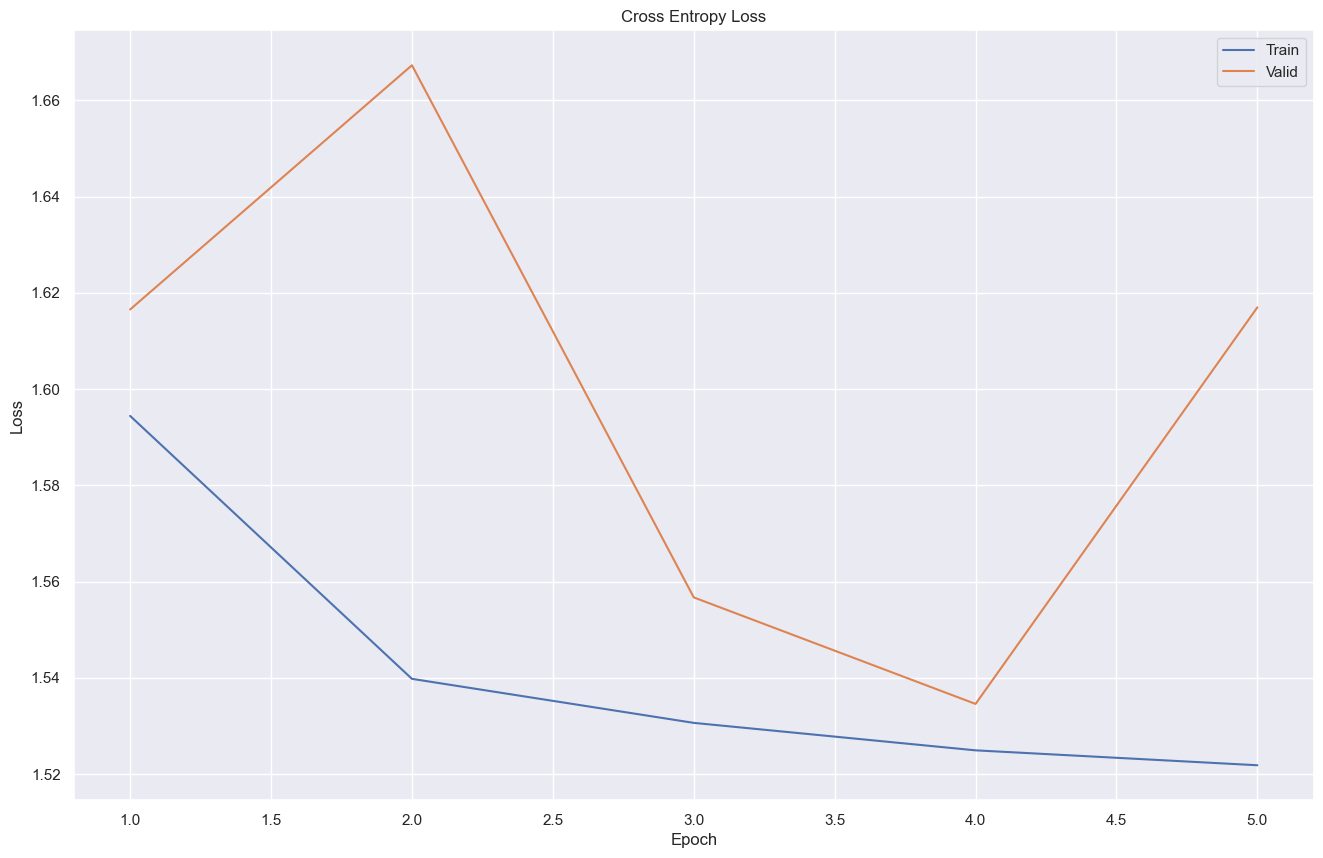

In [20]:
# Display the training and validation loss curves

cnn_plot.show_loss(
	report   = report,
	title    = 'Cross Entropy Loss',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

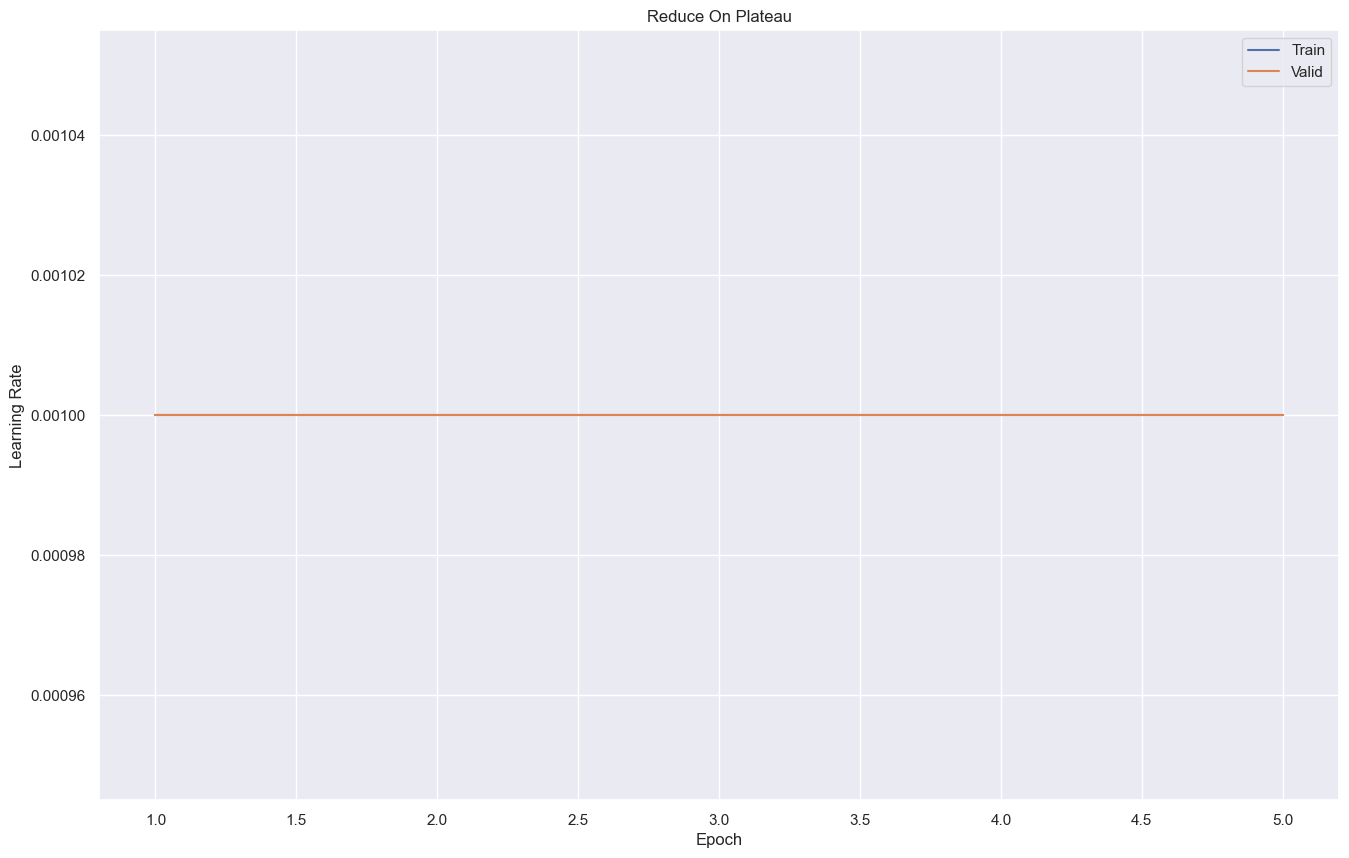

In [21]:
# Display the training and validation learning rate curves

cnn_plot.show_lr(
	report   = report,
	title    = 'Reduce On Plateau',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

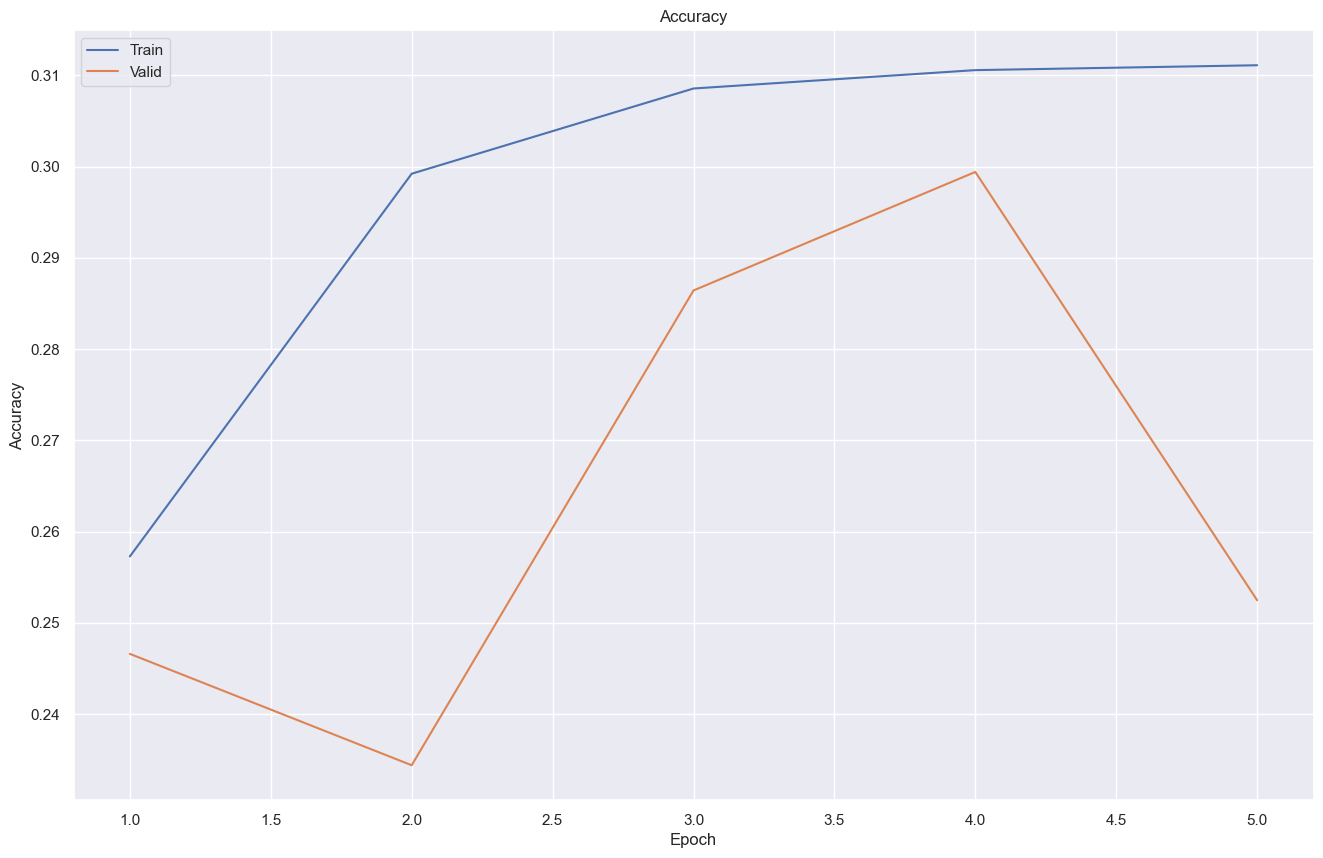

In [22]:
# Display the training and validation accuracy curves

cnn_plot.show_accuracy(
	report   = report,
	title    = 'Accuracy',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

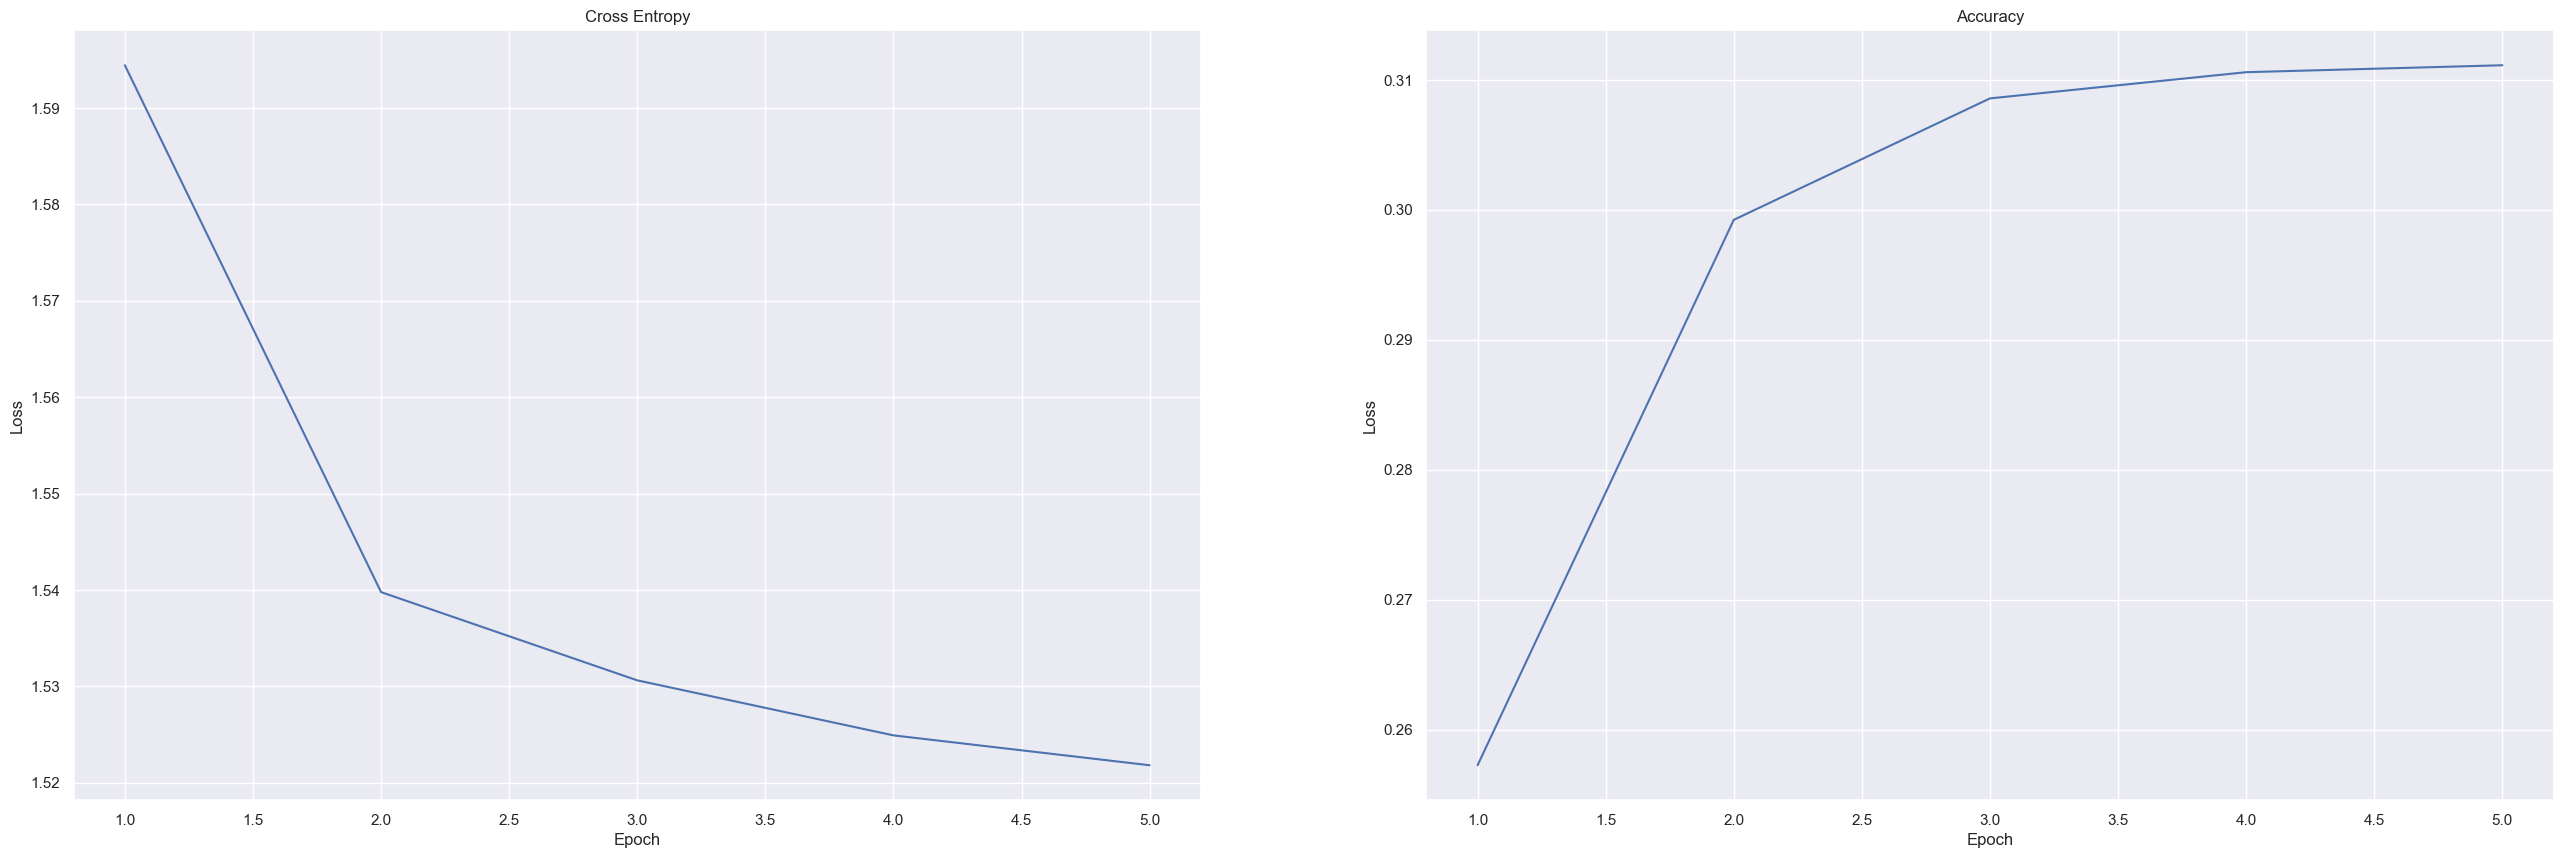

In [23]:
# Display the training metrics per batch

cnn_plot.show_metric_grid(
	report   = report,
	mode     = 'train',
	filename = os.path.join(OUT_PLOT, model.__name__ + '-train')
)

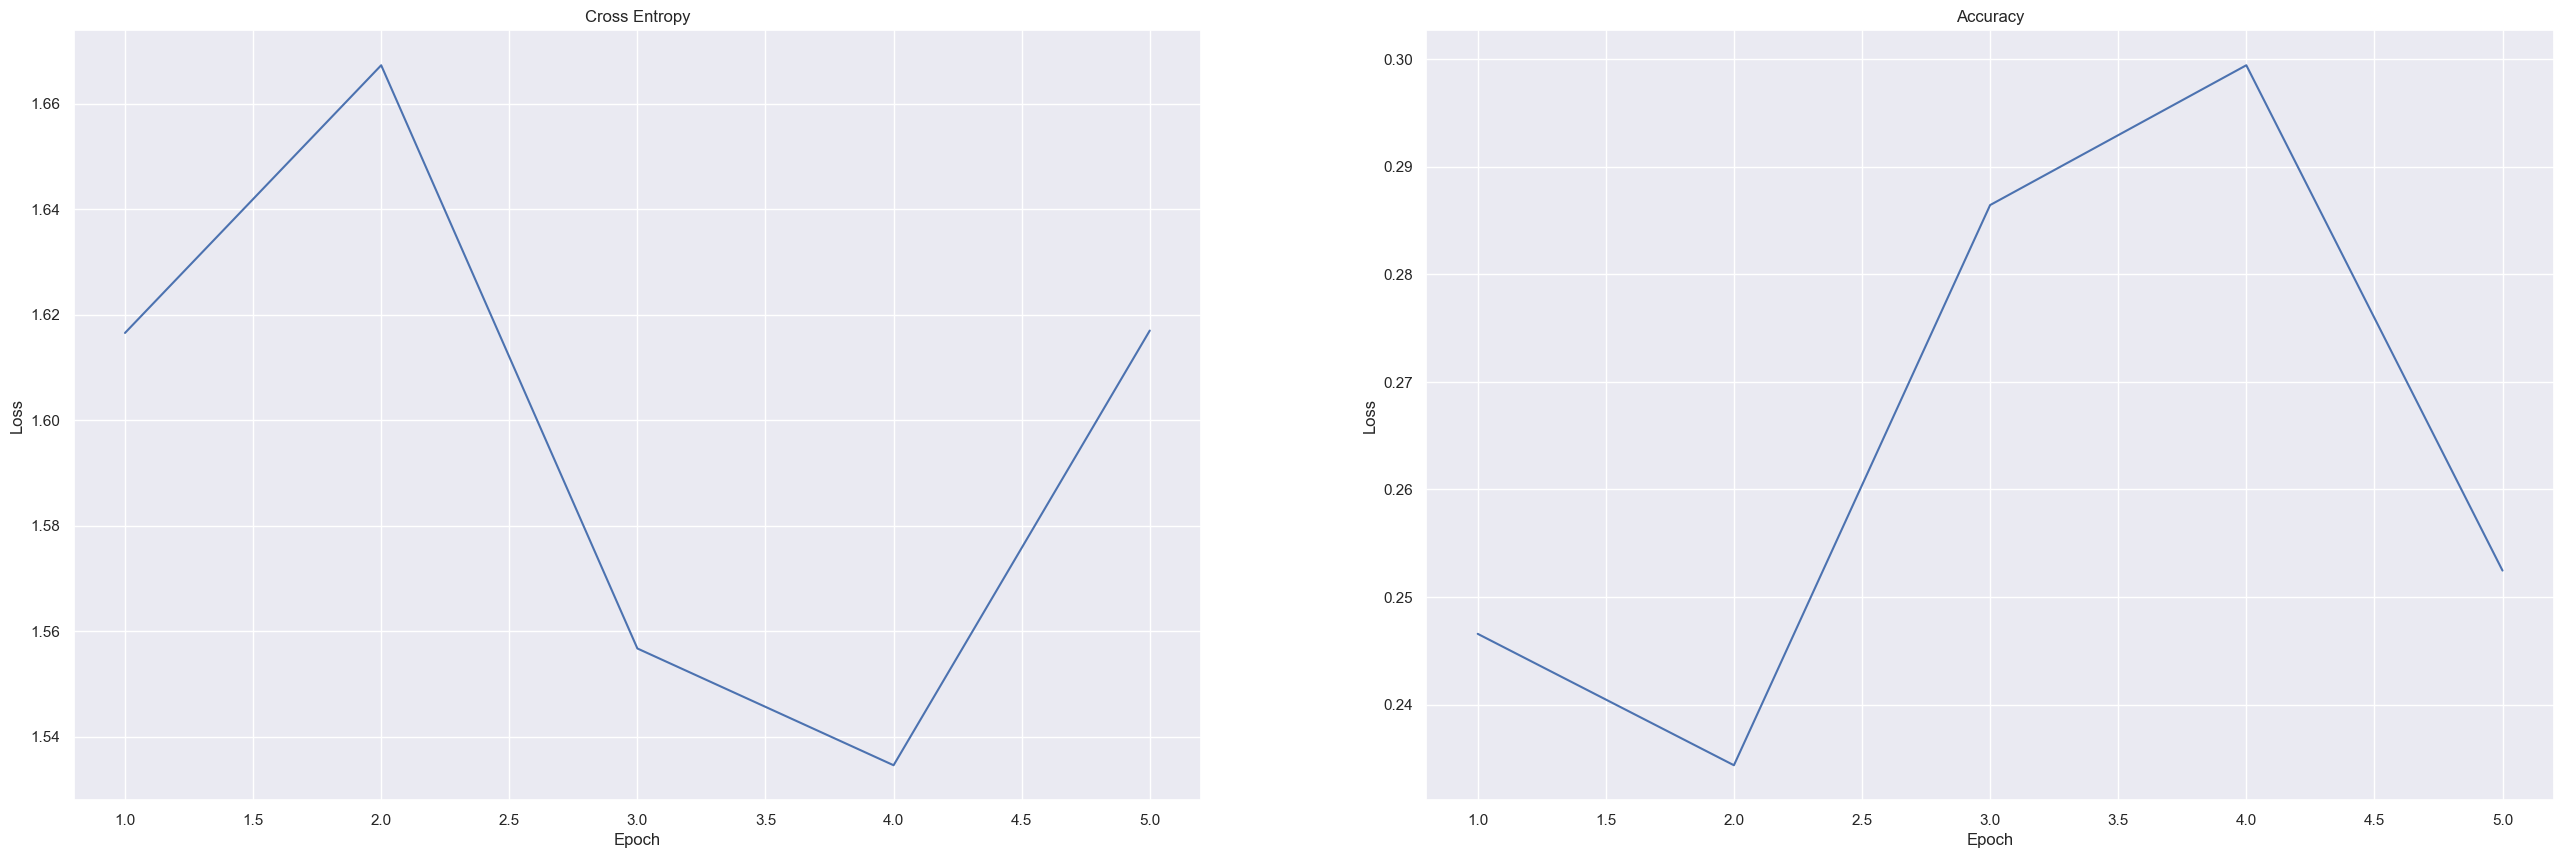

In [24]:
# Display the validation metrics per batch

cnn_plot.show_metric_grid(
	report   = report,
	mode     = 'valid',
	filename = os.path.join(OUT_PLOT, model.__name__ + '-valid')
)

# 5. Evaluation

## 5.1 Last Model

### 5.1.1 Evaluation

In [25]:
# Load last model

checkpoint = data_loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-last.pth')
)

print('Epoch : ' + '{}'.format(checkpoint['epoch']))
print('Loss  : ' + '{:.5f}'.format(checkpoint['loss']))

model.load_state_dict(checkpoint['models'])

Epoch : 5
Loss  : 1.61698


<All keys matched successfully>

In [26]:
# Evaluate the full model

report = cnn_model.eval_classifier(
	model  = model,
	params = model_params
)

print('Accuracy : ' + '{: 8.5f}'.format(report['eval']['metric']['accuracy'].mean()))
print('Entropy  : ' + '{: 8.5f}'.format(report['eval']['metric']['entropy'].mean()))

  0%|          | 0/190 [00:00<?, ?it/s]

Accuracy :  0.24757
Entropy  :  1.62461


### 5.1.2 Custom

In [27]:
# Display the first few evaluation item predictions and expectations

cnn_util.display_classification_predictions(report = report, n = 2)

Gene     : AT3G02460.4
True     : [2 1 2 1 1]
Pred     : [1 0 0 0 0]
Entropy  : [1.52919   1.47735   1.59322   1.41786   1.50439]
Accuracy : [0.00000   0.00000   0.00000   0.00000   0.00000]

Gene     : AT5G55550.8
True     : [0 0 0 0 0]
Pred     : [0 0 0 0 0]
Entropy  : [1.30740   0.68152   0.97422   0.77083   0.88028]
Accuracy : [1.00000   1.00000   1.00000   1.00000   1.00000]



In [28]:
# Display the evaluation accuracy

dataframe = cnn_util.display_classification_accuracy(
	report = report,
	order  = target_order
).sort_values('Accuracy', ascending = False)

print('Average Accuracy : {:8.5f} %'.format(dataframe['Accuracy'].mean()))
print('Average Missed 1 : {:8.5f} %'.format(dataframe['Missed_1'].mean()))
print('Average Missed 2 : {:8.5f} %'.format(dataframe['Missed_2'].mean()))
print('Average Missed 3 : {:8.5f} %'.format(dataframe['Missed_3'].mean()))
print('Average Missed 4 : {:8.5f} %'.format(dataframe['Missed_4'].mean()))
print()

dataframe

Average Accuracy : 24.75658 %
Average Missed 1 : 23.14803 %
Average Missed 2 : 19.95724 %
Average Missed 3 : 18.07237 %
Average Missed 4 : 14.06579 %



,Group,Total,Accuracy,Missed_1,Missed_2,Missed_3,Missed_4
1,leaf,6080,28.553,20.888,18.947,17.730,13.882
0,flower,6080,24.589,26.118,20.263,18.026,11.003
3,seed,6080,24.079,24.622,20.033,17.895,13.372
4,seedling,6080,23.421,22.138,20.312,18.438,15.691
2,root,6080,23.141,21.974,20.230,18.273,16.382


### 5.1.3 Visualization

### 5.1.4 Mutation

In [29]:
# Evaluate the mutations

report = cnn_model.eval_classifier(
	model  = model,
	params = model_params | {
		'test_dataloader' : mutation_dataloader,
		'metrics' : {
			'entropy'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'entropy'),
			'accuracy' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'accuracy')
		}
	}
)

print('Accuracy : ' + '{: 8.5f}'.format(report['eval']['metric']['accuracy'].mean()))
print('Entropy  : ' + '{: 8.5f}'.format(report['eval']['metric']['entropy'].mean()))

  0%|          | 0/2525 [00:00<?, ?it/s]

Accuracy :  0.27018
Entropy  :  1.64526


In [30]:
# Transform model report to mutation report

mutation_report = cnn_mutation.get_mutation_report(report = report)

transcript = list(mutation_report.keys())[0]
mutation   = list(mutation_report[transcript].keys())[0]

print('Transcripts : {}'.format(len(mutation_report)))
print('Mutations   : {}'.format(len(mutation_report[transcript])))
print('Variants    : {}'.format(len(mutation_report[transcript][mutation]['label'])))

Transcripts : 25
Mutations   : 6
Variants    : 20


In [31]:
# Print mutations

print(' ' + ' '.join(x if i % 10 != 0 else x + '\n' for i, x in enumerate(mutation_report.keys(), start = 1)))

 AT4G16146.1 AT3G12955.1 AT3G11730.1 AT1G05250.1 AT3G04640.1 AT1G34770.3 AT1G47500.2 AT2G26070.1 AT1G71370.1 AT5G46030.1
 AT2G27970.1 AT4G09600.1 AT4G19050.1 AT5G26570.1 AT2G03780.3 AT2G28370.1 AT4G14480.1 AT3G14610.1 AT1G55340.1 AT1G51690.2
 AT5G65530.1 AT2G21350.1 AT1G73750.1 AT4G34480.2 AT2G23770.1


In [32]:
# Plot single transcript mutation variant predictions

cnn_mutation.plot_mutation_classification(
	report     = mutation_report,
	transcript = None,
	mutation   = 'M01',
	order      = target_order
)

TODO - to be implemented


In [33]:
# Plot single transcript mutation variant predictions

cnn_mutation.plot_mutation_classification(
	report     = mutation_report,
	transcript = None,
	mutation   = 'M05',
	order      = target_order
)

TODO - to be implemented


In [34]:
# Plot single transcript mutation variant predictions

cnn_mutation.plot_mutation_classification(
	report     = mutation_report,
	transcript = None,
	mutation   = 'M10',
	order      = target_order
)

TODO - to be implemented


## 5.2 Best Model

### 5.2.1 Evaluation

In [35]:
# Load best model

checkpoint = data_loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-best.pth')
)

print('Epoch : ' + '{}'.format(checkpoint['epoch']))
print(' Loss : ' + '{:.5f}'.format(checkpoint['loss']))

model.load_state_dict(checkpoint['models'])

Epoch : 4
 Loss : 1.53456


<All keys matched successfully>

In [36]:
# Evaluate the full model

report = cnn_model.eval_classifier(
	model  = model,
	params = model_params
)

print('Accuracy : ' + '{: 8.5f}'.format(report['eval']['metric']['accuracy'].mean()))
print('Entropy  : ' + '{: 8.5f}'.format(report['eval']['metric']['entropy'].mean()))

  0%|          | 0/190 [00:00<?, ?it/s]

Accuracy :  0.30424
Entropy  :  1.53287


### 5.2.2 Custom

In [37]:
# Display the first few evaluation item predictions and expectations

cnn_util.display_classification_predictions(report = report, n = 2)

Gene     : AT3G59500.1
True     : [4 4 4 4 4]
Pred     : [4 4 4 4 4]
Entropy  : [0.95969   1.40855   1.01245   1.24405   1.25898]
Accuracy : [1.00000   1.00000   1.00000   1.00000   1.00000]

Gene     : AT4G25150.1
True     : [3 1 2 1 2]
Pred     : [3 2 3 2 2]
Entropy  : [1.34320   1.55273   1.51980   1.46638   1.41823]
Accuracy : [1.00000   0.00000   0.00000   0.00000   1.00000]



In [38]:
# Display the evaluation accuracy

dataframe = cnn_util.display_classification_accuracy(
	report = report,
	order  = target_order
).sort_values('Accuracy', ascending = False)

print('Average Accuracy : {:8.5f} %'.format(dataframe['Accuracy'].mean()))
print('Average Missed 1 : {:8.5f} %'.format(dataframe['Missed_1'].mean()))
print('Average Missed 2 : {:8.5f} %'.format(dataframe['Missed_2'].mean()))
print('Average Missed 3 : {:8.5f} %'.format(dataframe['Missed_3'].mean()))
print('Average Missed 4 : {:8.5f} %'.format(dataframe['Missed_4'].mean()))
print()

dataframe

Average Accuracy : 30.42434 %
Average Missed 1 : 27.42763 %
Average Missed 2 : 20.17105 %
Average Missed 3 : 13.60197 %
Average Missed 4 :  8.37500 %



,Group,Total,Accuracy,Missed_1,Missed_2,Missed_3,Missed_4
0,flower,6080,31.184,26.382,19.539,14.671,8.224
1,leaf,6080,30.970,26.711,21.266,11.924,9.128
3,seed,6080,30.905,29.605,19.375,13.668,6.447
2,root,6080,29.572,25.954,19.770,14.951,9.753
4,seedling,6080,29.490,28.487,20.905,12.796,8.322


### 5.2.3 Visualization

### 5.2.4 Mutation

In [39]:
# Evaluate the mutations

report = cnn_model.eval_classifier(
	model  = model,
	params = model_params | {
		'test_dataloader' : mutation_dataloader,
		'metrics' : {
			'entropy'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'entropy'),
			'accuracy' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'accuracy')
		}
	}
)

print('Accuracy : ' + '{: 8.5f}'.format(report['eval']['metric']['accuracy'].mean()))
print('Entropy  : ' + '{: 8.5f}'.format(report['eval']['metric']['entropy'].mean()))

  0%|          | 0/2525 [00:00<?, ?it/s]

Accuracy :  0.36483
Entropy  :  1.50925


In [40]:
# Transform model report to mutation report

mutation_report = cnn_mutation.get_mutation_report(report = report)

transcript = list(mutation_report.keys())[0]
mutation   = list(mutation_report[transcript].keys())[0]

print('Transcripts : {}'.format(len(mutation_report)))
print('Mutations   : {}'.format(len(mutation_report[transcript])))
print('Variants    : {}'.format(len(mutation_report[transcript][mutation]['label'])))

Transcripts : 25
Mutations   : 6
Variants    : 20


In [41]:
# Print mutations

print(' ' + ' '.join(x if i % 10 != 0 else x + '\n' for i, x in enumerate(mutation_report.keys(), start = 1)))

 AT5G46030.1 AT4G09600.1 AT2G23770.1 AT4G16146.1 AT2G28370.1 AT3G14610.1 AT3G12955.1 AT1G55340.1 AT1G34770.3 AT2G27970.1
 AT4G14480.1 AT3G04640.1 AT2G03780.3 AT3G11730.1 AT2G26070.1 AT5G26570.1 AT1G73750.1 AT4G19050.1 AT4G34480.2 AT1G05250.1
 AT5G65530.1 AT1G71370.1 AT1G51690.2 AT1G47500.2 AT2G21350.1


In [42]:
# Plot single transcript mutation variant predictions

cnn_mutation.plot_mutation_classification(
	report     = mutation_report,
	transcript = None,
	mutation   = 'M01',
	order      = target_order
)

TODO - to be implemented


In [43]:
# Plot single transcript mutation variant predictions

cnn_mutation.plot_mutation_classification(
	report     = mutation_report,
	transcript = None,
	mutation   = 'M05',
	order      = target_order
)

TODO - to be implemented


In [44]:
# Plot single transcript mutation variant predictions

cnn_mutation.plot_mutation_classification(
	report     = mutation_report,
	transcript = None,
	mutation   = 'M10',
	order      = target_order
)

TODO - to be implemented
